In [1]:
# suponha que ele preve ruptura em 2 dias. Depois desses 2 dias nao teve mais ruptura. Mas como eu nao aviso ele continua na previsao.
# ranqueamento das lojas

# Historico
- Rede dupla e/ou com 100 neuronios: ruim. Nos primeiros passos o resultado fica razoavel, mas quando avanca piora.
- Rede unica com 10 neuronios: bom.

In [1]:
#https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
import sys 
import json
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph 
import math
import collections
import pandas as pd

## for Deep-learing:
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.models import model_from_json
from tensorflow.python.keras.callbacks import TensorBoard

from itertools import product
from functools import partial
from time import time

from core.DataExploration import DataExploration
from ruptura.CreateBatch import CreateBatch
from ruptura.RupturaPrediction import RupturaPrediction
from ruptura.RupturaNeuralNetwork import RupturaNeuralNetwork

Using TensorFlow backend.


# CARREGAMENTO DOS DADOS

In [2]:
createBatch = CreateBatch()
amostras = createBatch.loadBatch()
X, Y, Ytest = createBatch.batch(amostras,nDiasTreino = 60, nDiasTeste = 10)

# MODEL DEFINITION

In [7]:
#DEFINE THE MODEL
rupNN = RupturaNeuralNetwork()
newModel = False

if newModel:
    n_neurons = 10
    batch_size = X.shape[0]
    time_steps = X.shape[1]
    x_dimension = X.shape[2]
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    model.add(TimeDistributed(Dense(x_dimension, activation='softmax')))
    #model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    #model.add(TimeDistributed(Dense(x_dimension, activation='softmax')))
    model.compile(
        loss=rupNN.getCustomLoss(Y),
        #loss = 'categorical_crossentropy', 
        optimizer='adam')
    print(model.summary())
else:
    model = rupNN.loadModel(Y)  # Y dimensions are needed for custom loss definitions
    print('model loaded')

model loaded


# TRAINING

In [ ]:
for step in range(10):
    n_epoch = 100
    model.fit(X, Y, 
                  epochs=n_epoch, 
                  batch_size= X.shape[0], 
                  #validation_data=(Xval, Yval),
                  verbose=2)
    rupNN.saveModel(model)

# VALIDATION

Contratos adimplentes:   9628
Contratos inadimlentes:  690
xAxis:   [2.0, 24.5, 47.0, 69.5, 92.0] 

yAxis:   [2, 4, 16, 28, 24] 



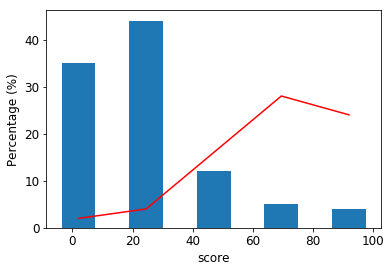

In [10]:
rupPred = RupturaPrediction(X)
model = rupNN.loadModel()
rupPred.validate(Ytest, model)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(range(len(resPlot)), resPlot, 'r.', label='PREVISTO, x') # x
plt.plot(range(len(yPlot)),yPlot, 'b.', label='REAL, y') # y
plt.legend(loc='best')
plt.show()  